<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

class_distribution = df["Rating"].value_counts().sort_index()
print(class_distribution)

1      842
2     1565
3     2871
4     5077
5    13131
Name: Rating, dtype: int64


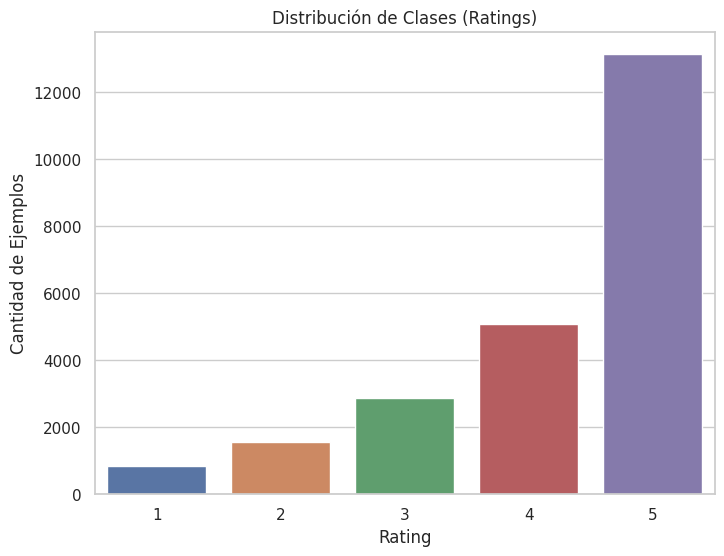

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x="Rating")
plt.title("Distribución de Clases (Ratings)")
plt.xlabel("Rating")
plt.ylabel("Cantidad de Ejemplos")
plt.show()

In [8]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

import numpy as np

# Tomar la columna de las reseñas
reviews = df_reviews['Review Text'].to_numpy()

# Vemos algunas reseñas
for i in range(5):
    print(f"Review {i+1}: {reviews[i]}")

# Almacenar las reseñas en un vector NumPy
reviews_np = np.array(reviews)

# Verificar la forma del vector de reseñas
print("Forma del vector de reseñas:", reviews_np.shape)


Review 1: Absolutely wonderful - silky and sexy and comfortable
Review 2: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite.  i bought a petite and am 5'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.
Review 3: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c
Review 4: I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing

In [9]:
# Alumno: Cuantas reviews (rows) hay para evaluar?

# Como vimos en el paso previo, tenemos 23486 reseñas.
num_reviews = len(reviews_np)
print("Número de reseñas:", num_reviews)


Número de reseñas: 22641


In [10]:
# Alumno: Concatenar todas las reviews para armar el corpus

corpus = ' '.join(reviews)

# Imprimir una porción del corpus como ejemplo
print("Ejemplo del corpus:", corpus[:200])

Ejemplo del corpus: Absolutely wonderful - silky and sexy and comfortable Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. 


In [11]:
# Alumno: ¿Cuál es la longitud de ese corpus?
print('La longitud del corpus es: ' ,len(corpus))

La longitud del corpus es:  7011643


In [12]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [13]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [14]:
# Alumno: ¿Cuántos tokens/palabras hay?
print('La cantidad de tokens es: ', len(tokens))

La cantidad de tokens es:  1372203


In [15]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(tokens)

In [16]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

word2index = tok.word_index
print('La cantidad total del vocabulario es: ', len(word2index))

La cantidad total del vocabulario es:  14847


In [17]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(reviews)

print(sequences[0])

[253, 532, 917, 3, 662, 3, 68]


In [18]:
# Alumno: Determinar cual es la oración más larga
max_sentence = max(len(s) for s in sequences)
print('La sentencia mas larga es: ', max_sentence)

La sentencia mas larga es:  115


In [19]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = max_sentence
X = pad_sequences(sequences, padding='pre', maxlen=max_sentence)


In [20]:
# Alumno: Observar las dimensiones de la variable input
print(X.shape)

(22641, 115)


In [21]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = df_reviews["Rating"].to_numpy()
y_one_hot = to_categorical(y)

In [22]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, stratify=y_one_hot, random_state=42)

In [23]:
# Alumno: determinar la dimensiones de entrada y salida
print('Dimensión de entrada: ', X_train.shape, y_train.shape)
print('Dimensión de salida: ', X_test.shape, y_test.shape)

Dimensión de entrada:  (18112, 115) (18112, 5)
Dimensión de salida:  (4529, 115) (4529, 5)


In [24]:
from imblearn.under_sampling import RandomUnderSampler

#Undersampling de las variables mayoritas para balancear el dataset de entrenamiento.

undersample = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

In [25]:
# Divido los datos en train y validation
X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_train_under, y_train_under, test_size=0.25, stratify=y_train_under, random_state=42)

In [34]:
num_classes = y_train_under.shape[1]
class_counts = np.sum(y_train_under, axis=0)

for class_idx in range(num_classes):
    print(f'Rating {class_idx+1}: {class_counts[class_idx]} clientes')

Rating 1: 493 clientes
Rating 2: 492 clientes
Rating 3: 493 clientes
Rating 4: 493 clientes
Rating 5: 492 clientes


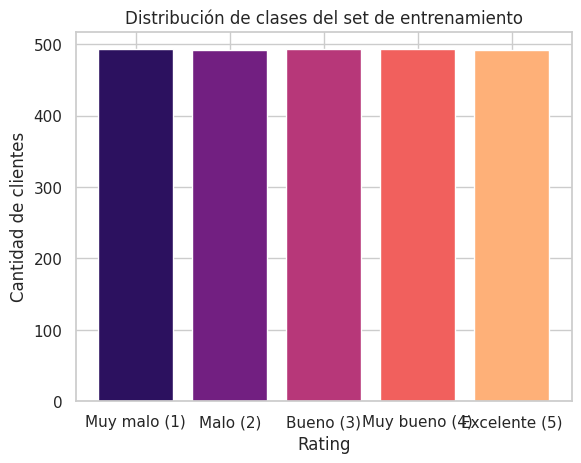

In [33]:
class_labels = ['Muy malo (1)', 'Malo (2)', 'Bueno (3)', 'Muy bueno (4)', 'Excelente (5)']
plt.bar(class_labels, class_counts, color = sns.color_palette("magma", num_classes))
plt.xlabel('Rating')
plt.ylabel('Cantidad de clientes')
plt.title('Distribución de clases del set de entrenamiento')
plt.show()

In [28]:
# Determinar la dimensiones de entrada y salida
in_shape = X_train_under.shape[1]
out_shape = y_train_under.shape[1]

print(f'Dimension de entrada: {in_shape} \nDimension de salida: {out_shape}')

Dimension de entrada: 115 
Dimension de salida: 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [29]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

In [30]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2746M  100 2746M    0     0   113M      0  0:00:24  0:00:24 --:--:--  194M


In [31]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128)) # La última capa LSTM no lleva return_sequences
model.add(Dropout(0.5))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 115, 128)          91648     
                                                                 
 dropout (Dropout)           (None, 115, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [35]:
# Entreno la red durante 50 epochs.
hist = model.fit(X_train_under, y_train_under, epochs=50, validation_data=(X_val_under,y_val_under))

Epoch 1/50
77/77 [==============================] - 12s 153ms/step - loss: 1.4979 - accuracy: 0.2968 - val_loss: 1.3726 - val_accuracy: 0.3467
Epoch 2/50
77/77 [==============================] - 8s 100ms/step - loss: 1.3061 - accuracy: 0.3683 - val_loss: 1.3612 - val_accuracy: 0.3333
Epoch 3/50
77/77 [==============================] - 5s 63ms/step - loss: 1.2127 - accuracy: 0.3922 - val_loss: 1.2910 - val_accuracy: 0.4148
Epoch 4/50
77/77 [==============================] - 2s 26ms/step - loss: 1.1039 - accuracy: 0.4848 - val_loss: 1.3841 - val_accuracy: 0.3759
Epoch 5/50
77/77 [==============================] - 2s 30ms/step - loss: 0.9825 - accuracy: 0.5554 - val_loss: 1.4433 - val_accuracy: 0.4173
Epoch 6/50
77/77 [==============================] - 3s 35ms/step - loss: 0.8541 - accuracy: 0.6208 - val_loss: 1.5955 - val_accuracy: 0.4039
Epoch 7/50
77/77 [==============================] - 3s 37ms/step - loss: 0.7762 - accuracy: 0.6646 - val_loss: 1.8271 - val_accuracy: 0.4002
Epoch 8/50

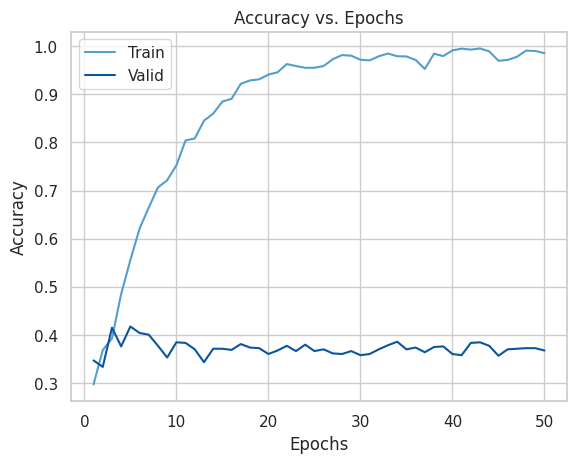

In [36]:
# Grafico Accuracy
blues_palette = sns.color_palette("Blues")
epoch_count = range(1, len(hist.history["accuracy"]) + 1)
sns.lineplot(x=epoch_count, y=hist.history["accuracy"], label="Train",color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist.history["val_accuracy"], label="Valid", color=blues_palette[5])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')
plt.show()

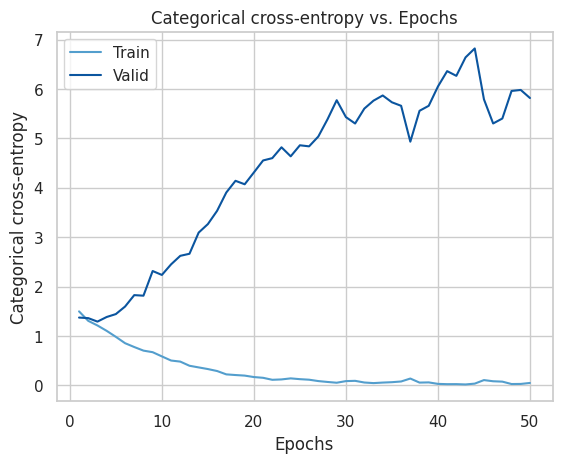

In [37]:
# Grafico loss function
epoch_count = range(1, len(hist.history["loss"]) + 1)
sns.lineplot(x=epoch_count, y=hist.history["loss"], label="Train",color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist.history["val_loss"], label="Valid", color=blues_palette[5])
plt.ylabel('Categorical cross-entropy')
plt.xlabel('Epochs')
plt.title('Categorical cross-entropy vs. Epochs')
plt.show()

In [38]:
# Evalúo el set de testeo
model.evaluate(X_test, y_test)

142/142 [==============================] - 3s 7ms/step - loss: 5.3477 - accuracy: 0.4191


[5.347706317901611, 0.419077068567276]

In [39]:
from sklearn.metrics import classification_report

y_pred_prob = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Convierto y_test al mismo formato que las labels de predicción
y_test_labels = np.argmax(y_test, axis=1)

# Uso el classification_report de scikit-learn
report = classification_report(y_test_labels, y_pred_labels)

print(report)

142/142 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.12      0.33      0.18       164
           1       0.19      0.30      0.23       310
           2       0.22      0.32      0.26       565
           3       0.28      0.35      0.31       982
           4       0.79      0.49      0.61      2508

    accuracy                           0.42      4529
   macro avg       0.32      0.36      0.32      4529
weighted avg       0.55      0.42      0.46      4529



Text(93.74999999999999, 0.5, 'Predicted class')

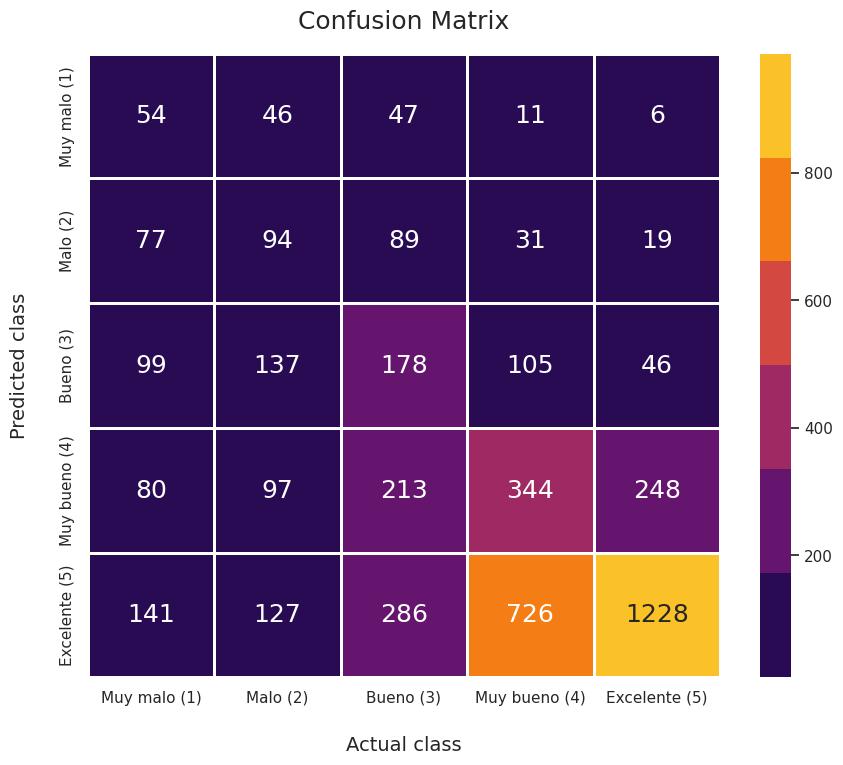

In [40]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_labels,y_pred_labels)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a = sns.color_palette("inferno")
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
#annot_kws: settings about annotations
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

## 3 - Entrenamiento del modelo con Embeddings Fasttext + LSTM

In [41]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [42]:
model_fasttext = FasttextEmbeddings()

In [43]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('Preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(vocab_size, len(word2index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word2index o bien elegir otra librería para preprocesamiento

for word, i in word2index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('Number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

Preparing embedding matrix...
Number of null word embeddings: 2


In [44]:
# Definimos el modelo
model2 = Sequential()

model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(out_shape, activation="softmax"))

model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_2 (LSTM)               (None, 115, 64)           93440     
                                                                 
 dropout_3 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [45]:
hist2 = model2.fit(X_train_under, y_train_under, epochs=100, validation_data=(X_val_under,y_val_under))

Epoch 1/100
77/77 [==============================] - 7s 35ms/step - loss: 1.6133 - accuracy: 0.2075 - val_loss: 1.6040 - val_accuracy: 0.2470
Epoch 2/100
77/77 [==============================] - 2s 24ms/step - loss: 1.5967 - accuracy: 0.2330 - val_loss: 1.5744 - val_accuracy: 0.2579
Epoch 3/100
77/77 [==============================] - 1s 18ms/step - loss: 1.5885 - accuracy: 0.2339 - val_loss: 1.5865 - val_accuracy: 0.2555
Epoch 4/100
77/77 [==============================] - 1s 17ms/step - loss: 1.5696 - accuracy: 0.2647 - val_loss: 1.5541 - val_accuracy: 0.2798
Epoch 5/100
77/77 [==============================] - 1s 17ms/step - loss: 1.5478 - accuracy: 0.2773 - val_loss: 1.5574 - val_accuracy: 0.2920
Epoch 6/100
77/77 [==============================] - 1s 17ms/step - loss: 1.5674 - accuracy: 0.2781 - val_loss: 1.5905 - val_accuracy: 0.2603
Epoch 7/100
77/77 [==============================] - 1s 18ms/step - loss: 1.5267 - accuracy: 0.2992 - val_loss: 1.5572 - val_accuracy: 0.2822
Epoch 

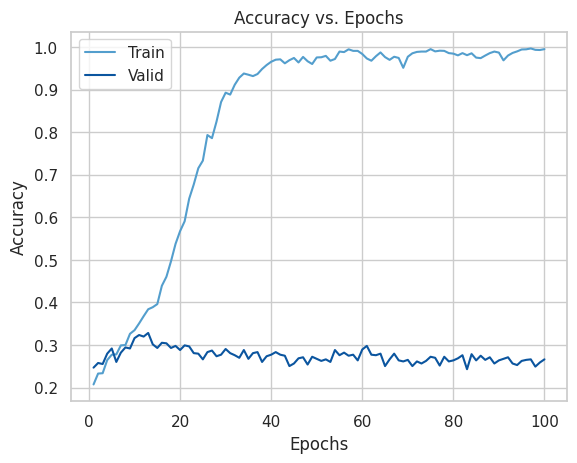

In [46]:
# Grafico Accuracy
blues_palette = sns.color_palette("Blues")
epoch_count = range(1, len(hist2.history["accuracy"]) + 1)
sns.lineplot(x=epoch_count, y=hist2.history["accuracy"], label="Train",color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist2.history["val_accuracy"], label="Valid", color=blues_palette[5])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')
plt.show()

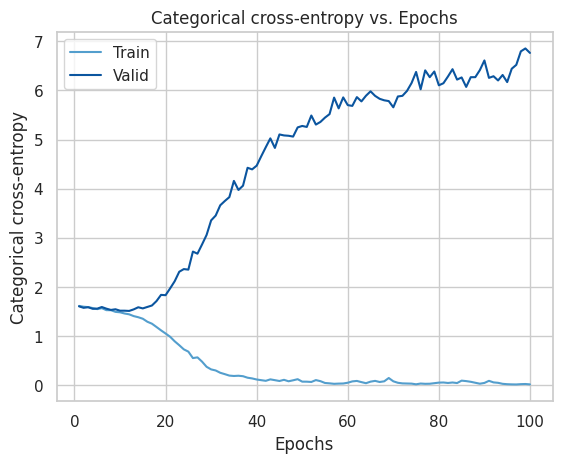

In [47]:
# Grafico loss function
epoch_count = range(1, len(hist2.history["loss"]) + 1)
sns.lineplot(x=epoch_count, y=hist2.history["loss"], label="Train",color=blues_palette[3])
sns.lineplot(x=epoch_count, y=hist2.history["val_loss"], label="Valid", color=blues_palette[5])
plt.ylabel('Categorical cross-entropy')
plt.xlabel('Epochs')
plt.title('Categorical cross-entropy vs. Epochs')
plt.show()

In [48]:
# Evalúo el set de testeo
model2.evaluate(X_test, y_test)

142/142 [==============================] - 3s 12ms/step - loss: 6.1676 - accuracy: 0.3045


[6.167564868927002, 0.30448222160339355]

In [49]:
from sklearn.metrics import classification_report

y_pred_prob = model2.predict(X_test)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Convierto y_test al mismo formato que las labels de predicción
y_test_labels = np.argmax(y_test, axis=1)

# Uso el classification_report de scikit-learn
report = classification_report(y_test_labels, y_pred_labels)

print(report)

142/142 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.07      0.29      0.12       164
           1       0.11      0.28      0.16       310
           2       0.16      0.23      0.19       565
           3       0.25      0.27      0.26       982
           4       0.69      0.34      0.46      2508

    accuracy                           0.30      4529
   macro avg       0.26      0.28      0.24      4529
weighted avg       0.47      0.30      0.35      4529



Text(93.74999999999999, 0.5, 'Predicted class')

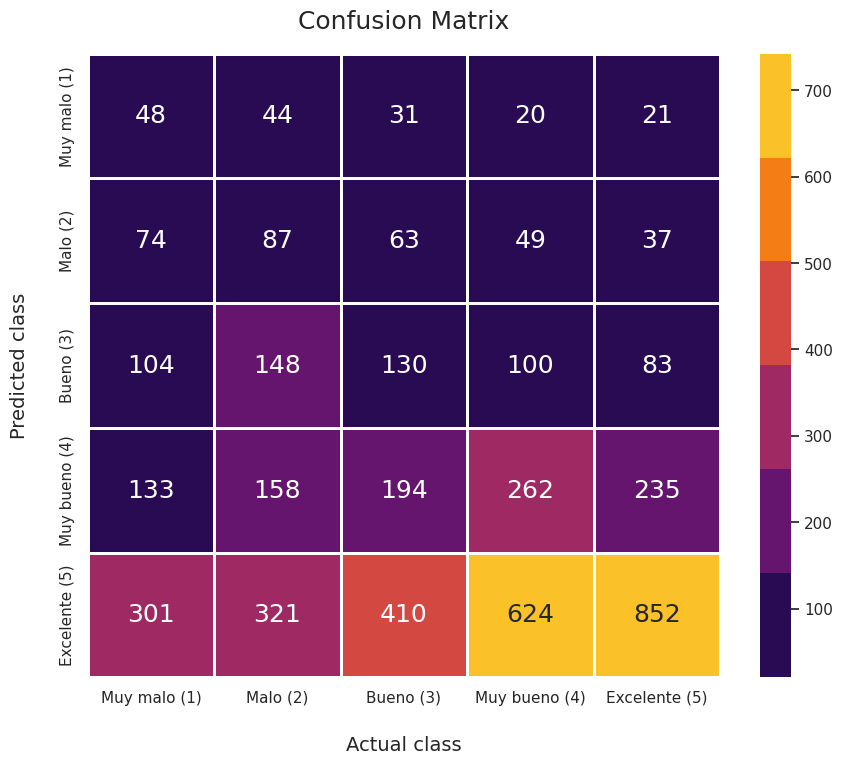

In [50]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_labels,y_pred_labels)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a = sns.color_palette("inferno")
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
#annot_kws: settings about annotations
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)

## 4 - Testing

In [51]:
# Diccionario de indices a palabras
index2word = {index: word for word, index in word2index.items()}
index2word[0] = ''

# Seleccion de reviews random
for i in range(5):
    idx = np.random.randint(len(y_test))
    review_tokens = [index2word[word] for word in X_test[idx]]
    review = " ".join(review_tokens).lstrip()

    # Predicciones de ambos modelos
    pred1 = model.predict(X_test[idx].reshape(1, -1))
    pred2 = model2.predict(X_test[idx].reshape(1, -1))

    print(f"Review {i+1}: {review}")
    print(f"Predicción modelo 1: {np.argmax(pred1)}")
    print(f"Predicción modelo 2: {np.argmax(pred2)}")
    print(f"Valor verdadero: {np.argmax(y_test[idx])}")
    print('-'*85)

1/1 [==============================] - 0s 30ms/step
Review 1: beautiful timeless dress runs small straight fit can't wait to wear it to work or a
Predicción modelo 1: 3
Predicción modelo 2: 4
Valor verdadero: 4
-------------------------------------------------------------------------------------
1/1 [==============================] - 0s 25ms/step
Review 2: the material looked much nicer in the online picture also there are pockets which added a bulk to it that was not flattering on me
Predicción modelo 1: 0
Predicción modelo 2: 2
Valor verdadero: 2
-------------------------------------------------------------------------------------
1/1 [==============================] - 0s 27ms/step
Review 3: i love love love this top so flattering and comfortable looks great with jeans leggings or i totally plan to use it as a beach cover up as well they only had medium left i usually get xs s but it was still as flattering and i usually like my clothes on the roomy side
Predicción modelo 1: 4
Predic

## Conclusiones

Se experimentaron varias arquitecturas con el fin de mejorar el rendimiento del modelo. Se hicieron ajustes al número de capas, configuración de hiperparámetros como el número de nodos, dropout, el optimizador y la velocidad de aprendizaje. A pesar de todo, no se logró una tasa de precisión superior al 40 % en el conjunto de pruebas.

Sin embargo, al realizar múltiples predicciones en el conjunto de prueba, se observa que las predicciones generalmente no son desfavorables. Es importante señalar que no se encontraron casos en los que se predijera el valor opuesto, como calificar la categoría 0 (Muy pobre) cuando en realidad es 4 (Excelente), o viceversa. Por lo tanto, se infiere que este modelo tiene al menos la capacidad de discernir entre emociones positivas y negativas.

Una posibilidad para mejorar el rendimiento podría ser transformar este problema en una clasificación binaria, de manera de que sea mas directa la clasificación determinando si el cliente está o no satisfecho con el producto. Otra alternativa podría ser cambiar la estrategia de equilibrio del conjunto de datos, utilizando sobremuestreo en lugar de submuestreo, lo que permitiría igualar el tamaño de todas las clases al mayor, aunque a costa de un mayor procesamiento de datos.